Optimized Distance: 0.02861760896077375 meters
Optimized Wavelength: 7.101437889620248e-07 meters
Optimized Pixel Size: 7.2490965171753025e-06 meters


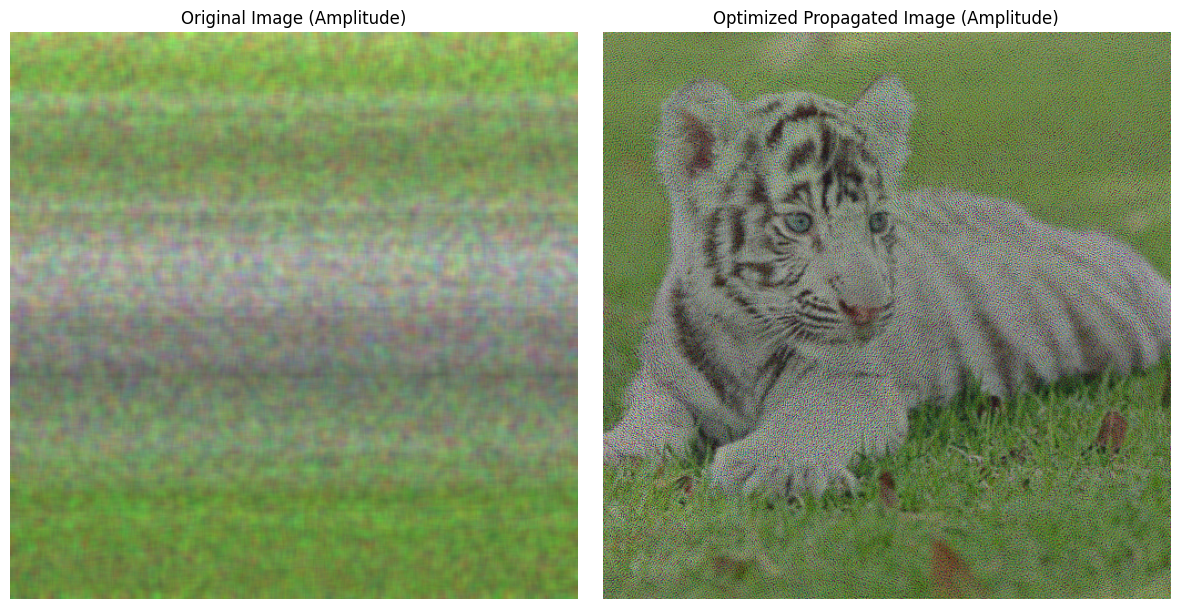

In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from scipy.optimize import minimize
from skimage.metrics import structural_similarity as ssim
from skimage.filters import sobel

# Propagation function using Fourier optics principles
def propagate(field, distance, wavelength, pixel_size):
    """
    Parameters:
        field: torch.Tensor - The input complex field (HxW complex tensor)
        distance: float - Propagation distance in meters
        wavelength: float - Wavelength in meters
        pixel_size: float - Pixel size in meters
    Returns:
        torch.Tensor - Propagated field
    """
    H, W = field.shape
    k = 2 * np.pi / wavelength  # Wavenumber

    # Create frequency coordinates
    fx = torch.fft.fftfreq(W, d=pixel_size, device=field.device)
    fy = torch.fft.fftfreq(H, d=pixel_size, device=field.device)
    FX, FY = torch.meshgrid(fx, fy, indexing='ij')
    F2 = FX**2 + FY**2

    # Transfer function for free-space propagation
    sqrt_term = torch.clamp(1 - (wavelength**2) * F2, min=0)
    distance_tensor = torch.tensor(distance, device=field.device, dtype=field.dtype)
    H = torch.exp(-1j * k * distance_tensor * torch.sqrt(sqrt_term))

    # Apply the propagation in Fourier domain
    field_ft = torch.fft.fft2(field)
    field_ft_prop = field_ft * H
    propagated_field = torch.fft.ifft2(field_ft_prop)

    return propagated_field

# Loss function for optimization
def loss_function(params, field, original_image):
    """
    Loss function that maximizes edge preservation and differences from the original image.
    """
    distance, wavelength, pixel_size = params
    propagated_field = propagate(field, distance, wavelength, pixel_size)
    propagated_amplitude = torch.abs(propagated_field).cpu().numpy()

    # Difference from the original image
    difference = np.mean(np.abs(original_image - propagated_amplitude))

    # Edge preservation using Sobel filter
    original_edges = sobel(original_image)
    propagated_edges = sobel(propagated_amplitude)
    edge_preservation = -np.mean((original_edges - propagated_edges) ** 2)

    # Weighted combination of difference and edge preservation
    return -0.5 * difference + 0.5 * edge_preservation

# Load unknown.npy
file_path = "unknown.npy"
data = np.load(file_path)

# Check dimensions and convert to complex64
if len(data.shape) != 3 or data.shape[2] != 3:
    raise ValueError("Input data must be a 3D array with dimensions (HxWx3).")
data = np.array(data, dtype=np.complex64)

# Convert data to PyTorch tensor
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_tensor = torch.tensor(data, dtype=torch.complex64, device=device)

# Initial guesses for distance, wavelength, and pixel size
initial_params = [30e-3, 600e-9, 10e-6]  # Initial guess: 30 mm, 600 nm, 10 μm
original_image = np.abs(data[:, :, 0])  # Original amplitude image (R channel)

# Optimize distance, wavelength, and pixel size for one channel (e.g., R channel)
result = minimize(
    fun=loss_function,
    x0=initial_params,
    args=(data_tensor[:, :, 0], original_image),
    bounds=[(5e-3, 100e-3), (400e-9, 800e-9), (5e-6, 50e-6)]
)

# Get optimized parameters
best_distance, best_wavelength, best_pixel_size = result.x
print(f"Optimized Distance: {best_distance} meters")
print(f"Optimized Wavelength: {best_wavelength} meters")
print(f"Optimized Pixel Size: {best_pixel_size} meters")

# Initialize propagated fields for each color channel
propagated_fields = []

# Perform propagation for each channel using the optimized parameters
for channel in range(3):
    field = data_tensor[:, :, channel]
    propagated_field = propagate(field, best_distance, best_wavelength, best_pixel_size)
    propagated_fields.append(torch.abs(propagated_field).cpu().numpy())

# Combine propagated channels into an RGB image
propagated_image = np.stack(propagated_fields, axis=-1)

# Normalize the propagated image for visualization
propagated_image_normalized = (propagated_image - np.min(propagated_image)) / (np.max(propagated_image) - np.min(propagated_image))

# Gamma correction for better visibility
gamma = 0.6  # Adjust gamma for brightness/contrast
propagated_image_normalized = propagated_image_normalized ** gamma

# Normalize original data for visualization
original_amplitude = np.abs(data)
original_amplitude_normalized = original_amplitude / np.max(original_amplitude)

# Plot the results
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.title("Original Image (Amplitude)")
plt.imshow(original_amplitude_normalized, cmap='viridis')
plt.axis('off')

# Propagated image
plt.subplot(1, 2, 2)
plt.title("Optimized Propagated Image (Amplitude)")
plt.imshow(propagated_image_normalized)
plt.axis('off')

plt.tight_layout()
plt.savefig("optimized_image.png", dpi=300)
plt.show()


Optimized Distance: 0.02861760896077375 meters
Optimized Wavelength: 7.101437889620248e-07 meters
Optimized Pixel Size: 7.2490965171753025e-06 meters


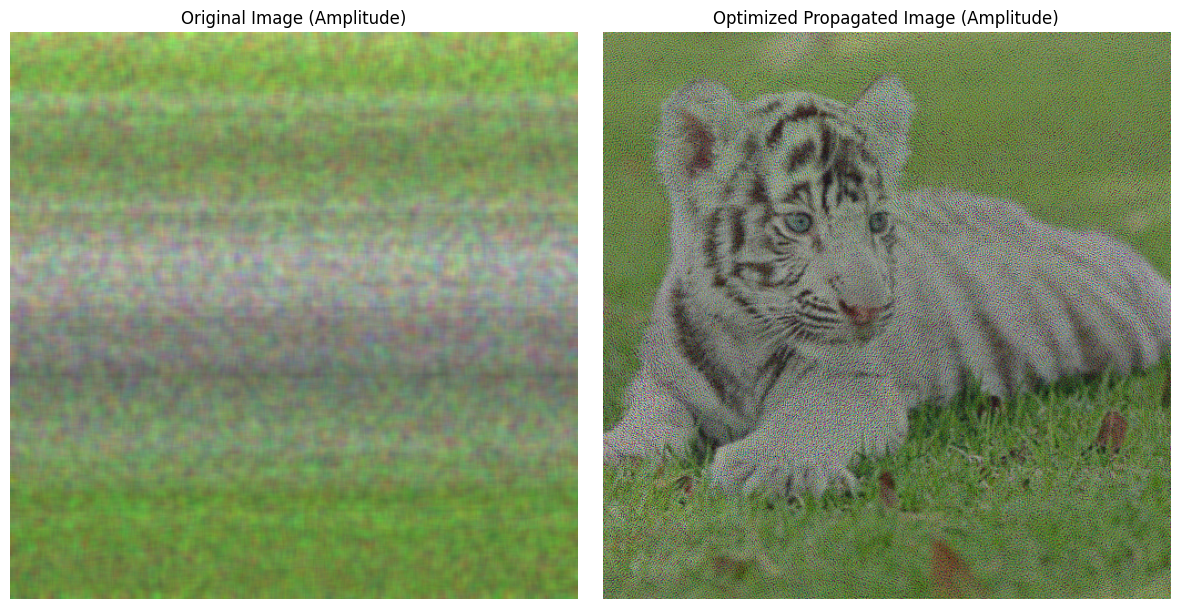

In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from scipy.optimize import minimize
from skimage.metrics import structural_similarity as ssim
from skimage.filters import sobel

# Propagation function using Fourier optics principles
def propagate(field, distance, wavelength, pixel_size):
    """
    Parameters:
        field: torch.Tensor - The input complex field (HxW complex tensor)
        distance: float - Propagation distance in meters
        wavelength: float - Wavelength in meters
        pixel_size: float - Pixel size in meters
    Returns:
        torch.Tensor - Propagated field
    """
    H, W = field.shape
    k = 2 * np.pi / wavelength  # Wavenumber

    # Create frequency coordinates
    fx = torch.fft.fftfreq(W, d=pixel_size, device=field.device)
    fy = torch.fft.fftfreq(H, d=pixel_size, device=field.device)
    FX, FY = torch.meshgrid(fx, fy, indexing='ij')
    F2 = FX**2 + FY**2

    # Transfer function for free-space propagation
    sqrt_term = torch.clamp(1 - (wavelength**2) * F2, min=0)
    distance_tensor = torch.tensor(distance, device=field.device, dtype=field.dtype)
    H = torch.exp(-1j * k * distance_tensor * torch.sqrt(sqrt_term))

    # Apply the propagation in Fourier domain
    field_ft = torch.fft.fft2(field)
    field_ft_prop = field_ft * H
    propagated_field = torch.fft.ifft2(field_ft_prop)

    return propagated_field

# Loss function for optimization
def loss_function(params, field, original_image):
    """
    Loss function that maximizes edge preservation and differences from the original image.
    """
    distance, wavelength, pixel_size = params
    propagated_field = propagate(field, distance, wavelength, pixel_size)
    propagated_amplitude = torch.abs(propagated_field).cpu().numpy()

    # Difference from the original image
    difference = np.mean(np.abs(original_image - propagated_amplitude))

    # Edge preservation using Sobel filter
    original_edges = sobel(original_image)
    propagated_edges = sobel(propagated_amplitude)
    edge_preservation = -np.mean((original_edges - propagated_edges) ** 2)

    # Weighted combination of difference and edge preservation
    return -0.5 * difference + 0.5 * edge_preservation

# Load unknown.npy
file_path = "unknown.npy"
data = np.load(file_path)

# Check dimensions and convert to complex64
if len(data.shape) != 3 or data.shape[2] != 3:
    raise ValueError("Input data must be a 3D array with dimensions (HxWx3).")
data = np.array(data, dtype=np.complex64)

# Convert data to PyTorch tensor
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_tensor = torch.tensor(data, dtype=torch.complex64, device=device)

# Initial guesses for distance, wavelength, and pixel size
initial_params = [30e-3, 600e-9, 10e-6]  # Initial guess: 30 mm, 600 nm, 10 μm
original_image = np.abs(data[:, :, 0])  # Original amplitude image (R channel)

# Optimize distance, wavelength, and pixel size for one channel (e.g., R channel)
result = minimize(
    fun=loss_function,
    x0=initial_params,
    args=(data_tensor[:, :, 0], original_image),
    bounds=[(5e-3, 100e-3), (400e-9, 800e-9), (5e-6, 50e-6)]
)

# Get optimized parameters
best_distance, best_wavelength, best_pixel_size = result.x
print(f"Optimized Distance: {best_distance} meters")
print(f"Optimized Wavelength: {best_wavelength} meters")
print(f"Optimized Pixel Size: {best_pixel_size} meters")

# Initialize propagated fields for each color channel
propagated_fields = []

# Perform propagation for each channel using the optimized parameters
for channel in range(3):
    field = data_tensor[:, :, channel]
    propagated_field = propagate(field, best_distance, best_wavelength, best_pixel_size)
    propagated_fields.append(torch.abs(propagated_field).cpu().numpy())

# Combine propagated channels into an RGB image
propagated_image = np.stack(propagated_fields, axis=-1)

# Normalize the propagated image for visualization
propagated_image_normalized = (propagated_image - np.min(propagated_image)) / (np.max(propagated_image) - np.min(propagated_image))

# Gamma correction for better visibility
gamma = 0.6  # Adjust gamma for brightness/contrast
propagated_image_normalized = propagated_image_normalized ** gamma

# Normalize original data for visualization
original_amplitude = np.abs(data)
original_amplitude_normalized = original_amplitude / np.max(original_amplitude)

# Plot the results
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.title("Original Image (Amplitude)")
plt.imshow(original_amplitude_normalized, cmap='viridis')
plt.axis('off')

# Propagated image
plt.subplot(1, 2, 2)
plt.title("Optimized Propagated Image (Amplitude)")
plt.imshow(propagated_image_normalized)
plt.axis('off')

plt.tight_layout()
plt.savefig("optimized_image.png", dpi=300)
plt.show()


Optimized Distance: 0.02861760896077375 meters
Optimized Wavelength: 7.101437889620248e-07 meters
Optimized Pixel Size: 7.2490965171753025e-06 meters


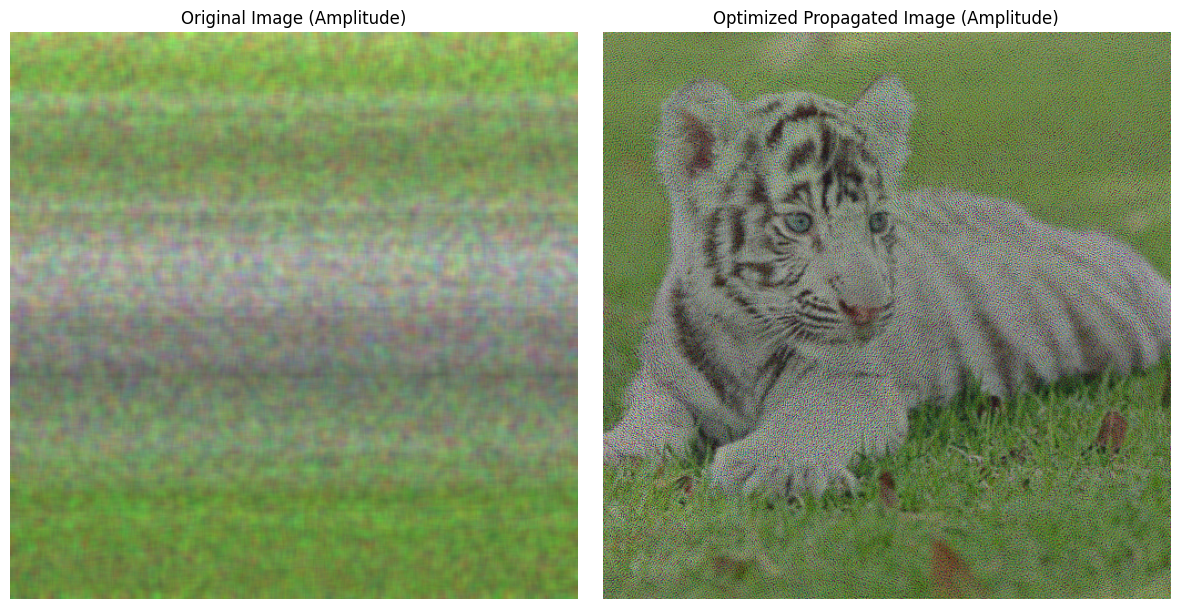

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from scipy.optimize import minimize
from skimage.metrics import structural_similarity as ssim
from skimage.filters import sobel

# Propagation function using Fourier optics principles
def propagate(field, distance, wavelength, pixel_size):
    """
    Parameters:
        field: torch.Tensor - The input complex field (HxW complex tensor)
        distance: float - Propagation distance in meters
        wavelength: float - Wavelength in meters
        pixel_size: float - Pixel size in meters
    Returns:
        torch.Tensor - Propagated field
    """
    H, W = field.shape
    k = 2 * np.pi / wavelength  # Wavenumber

    # Create frequency coordinates
    fx = torch.fft.fftfreq(W, d=pixel_size, device=field.device)
    fy = torch.fft.fftfreq(H, d=pixel_size, device=field.device)
    FX, FY = torch.meshgrid(fx, fy, indexing='ij')
    F2 = FX**2 + FY**2

    # Transfer function for free-space propagation
    sqrt_term = torch.clamp(1 - (wavelength**2) * F2, min=0)
    distance_tensor = torch.tensor(distance, device=field.device, dtype=field.dtype)
    H = torch.exp(-1j * k * distance_tensor * torch.sqrt(sqrt_term))

    # Apply the propagation in Fourier domain
    field_ft = torch.fft.fft2(field)
    field_ft_prop = field_ft * H
    propagated_field = torch.fft.ifft2(field_ft_prop)

    return propagated_field

# Loss function for optimization
def loss_function(params, field, original_image):
    """
    Loss function that maximizes edge preservation and differences from the original image.
    """
    distance, wavelength, pixel_size = params
    propagated_field = propagate(field, distance, wavelength, pixel_size)
    propagated_amplitude = torch.abs(propagated_field).cpu().numpy()

    # Difference from the original image
    difference = np.mean(np.abs(original_image - propagated_amplitude))

    # Edge preservation using Sobel filter
    original_edges = sobel(original_image)
    propagated_edges = sobel(propagated_amplitude)
    edge_preservation = -np.mean((original_edges - propagated_edges) ** 2)

    # Weighted combination of difference and edge preservation
    return -0.5 * difference + 0.5 * edge_preservation

# Load unknown.npy
file_path = "unknown.npy"
data = np.load(file_path)

# Check dimensions and convert to complex64
if len(data.shape) != 3 or data.shape[2] != 3:
    raise ValueError("Input data must be a 3D array with dimensions (HxWx3).")
data = np.array(data, dtype=np.complex64)

# Convert data to PyTorch tensor
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_tensor = torch.tensor(data, dtype=torch.complex64, device=device)

# Initial guesses for distance, wavelength, and pixel size
initial_params = [30e-3, 600e-9, 10e-6]  # Initial guess: 30 mm, 600 nm, 10 μm
original_image = np.abs(data[:, :, 0])  # Original amplitude image (R channel)

# Optimize distance, wavelength, and pixel size for one channel (e.g., R channel)
result = minimize(
    fun=loss_function,
    x0=initial_params,
    args=(data_tensor[:, :, 0], original_image),
    bounds=[(5e-3, 100e-3), (400e-9, 800e-9), (5e-6, 50e-6)]
)

# Get optimized parameters
best_distance, best_wavelength, best_pixel_size = result.x
print(f"Optimized Distance: {best_distance} meters")
print(f"Optimized Wavelength: {best_wavelength} meters")
print(f"Optimized Pixel Size: {best_pixel_size} meters")

# Initialize propagated fields for each color channel
propagated_fields = []

# Perform propagation for each channel using the optimized parameters
for channel in range(3):
    field = data_tensor[:, :, channel]
    propagated_field = propagate(field, best_distance, best_wavelength, best_pixel_size)
    propagated_fields.append(torch.abs(propagated_field).cpu().numpy())

# Combine propagated channels into an RGB image
propagated_image = np.stack(propagated_fields, axis=-1)

# Normalize the propagated image for visualization
propagated_image_normalized = (propagated_image - np.min(propagated_image)) / (np.max(propagated_image) - np.min(propagated_image))

# Gamma correction for better visibility
gamma = 0.6  # Adjust gamma for brightness/contrast
propagated_image_normalized = propagated_image_normalized ** gamma

# Normalize original data for visualization
original_amplitude = np.abs(data)
original_amplitude_normalized = original_amplitude / np.max(original_amplitude)

# Plot the results
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.title("Original Image (Amplitude)")
plt.imshow(original_amplitude_normalized, cmap='viridis')
plt.axis('off')

# Propagated image
plt.subplot(1, 2, 2)
plt.title("Optimized Propagated Image (Amplitude)")
plt.imshow(propagated_image_normalized)
plt.axis('off')

plt.tight_layout()
plt.savefig("optimized_image.png", dpi=512)
plt.show()


Optimized Distance: 0.02861760896077375 meters
Optimized Wavelength: 7.101437889620248e-07 meters
Optimized Pixel Size: 7.2490965171753025e-06 meters


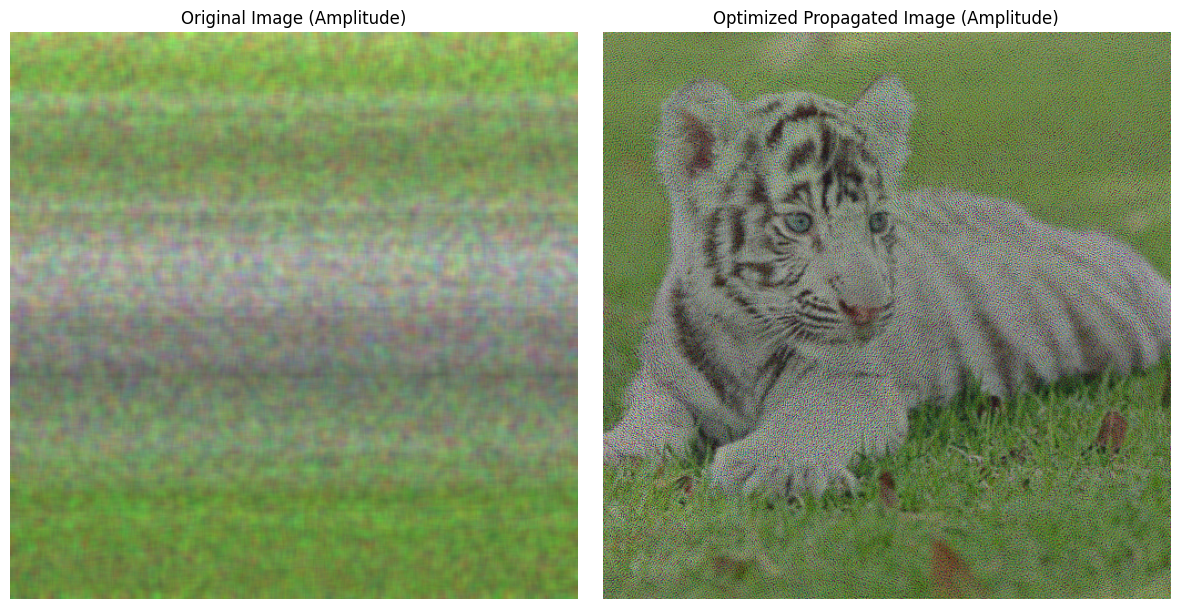

In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from scipy.optimize import minimize
from skimage.metrics import structural_similarity as ssim
from skimage.filters import sobel

# Propagation function using Fourier optics principles
def propagate(field, distance, wavelength, pixel_size):
    """
    Parameters:
        field: torch.Tensor - The input complex field (HxW complex tensor)
        distance: float - Propagation distance in meters
        wavelength: float - Wavelength in meters
        pixel_size: float - Pixel size in meters
    Returns:
        torch.Tensor - Propagated field
    """
    H, W = field.shape
    k = 2 * np.pi / wavelength  # Wavenumber

    # Create frequency coordinates
    fx = torch.fft.fftfreq(W, d=pixel_size, device=field.device)
    fy = torch.fft.fftfreq(H, d=pixel_size, device=field.device)
    FX, FY = torch.meshgrid(fx, fy, indexing='ij')
    F2 = FX**2 + FY**2

    # Transfer function for free-space propagation
    sqrt_term = torch.clamp(1 - (wavelength**2) * F2, min=0)
    distance_tensor = torch.tensor(distance, device=field.device, dtype=field.dtype)
    H = torch.exp(-1j * k * distance_tensor * torch.sqrt(sqrt_term))

    # Apply the propagation in Fourier domain
    field_ft = torch.fft.fft2(field)
    field_ft_prop = field_ft * H
    propagated_field = torch.fft.ifft2(field_ft_prop)

    return propagated_field

# Loss function for optimization
def loss_function(params, field, original_image):
    """
    Loss function that maximizes edge preservation and differences from the original image.
    """
    distance, wavelength, pixel_size = params
    propagated_field = propagate(field, distance, wavelength, pixel_size)
    propagated_amplitude = torch.abs(propagated_field).cpu().numpy()

    # Difference from the original image
    difference = np.mean(np.abs(original_image - propagated_amplitude))

    # Edge preservation using Sobel filter
    original_edges = sobel(original_image)
    propagated_edges = sobel(propagated_amplitude)
    edge_preservation = -np.mean((original_edges - propagated_edges) ** 2)

    # Weighted combination of difference and edge preservation
    return -0.5 * difference + 0.5 * edge_preservation

# Load unknown.npy
file_path = "unknown.npy"
data = np.load(file_path)

# Resize to 512x512
data_resized = zoom(data, (512 / data.shape[0], 512 / data.shape[1], 1), order=1)

# Check dimensions and convert to complex64
if len(data_resized.shape) != 3 or data_resized.shape[2] != 3:
    raise ValueError("Input data must be a 3D array with dimensions (HxWx3).")
data_resized = np.array(data_resized, dtype=np.complex64)

# Convert data to PyTorch tensor
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_tensor = torch.tensor(data_resized, dtype=torch.complex64, device=device)

# Initial guesses for distance, wavelength, and pixel size
initial_params = [30e-3, 600e-9, 10e-6]  # Initial guess: 30 mm, 600 nm, 10 μm
original_image = np.abs(data_resized[:, :, 0])  # Original amplitude image (R channel)

# Optimize distance, wavelength, and pixel size for one channel (e.g., R channel)
result = minimize(
    fun=loss_function,
    x0=initial_params,
    args=(data_tensor[:, :, 0], original_image),
    bounds=[(5e-3, 100e-3), (400e-9, 800e-9), (5e-6, 50e-6)]
)

# Get optimized parameters
best_distance, best_wavelength, best_pixel_size = result.x
print(f"Optimized Distance: {best_distance} meters")
print(f"Optimized Wavelength: {best_wavelength} meters")
print(f"Optimized Pixel Size: {best_pixel_size} meters")

# Initialize propagated fields for each color channel
propagated_fields = []

# Perform propagation for each channel using the optimized parameters
for channel in range(3):
    field = data_tensor[:, :, channel]
    propagated_field = propagate(field, best_distance, best_wavelength, best_pixel_size)
    propagated_fields.append(torch.abs(propagated_field).cpu().numpy())

# Combine propagated channels into an RGB image
propagated_image = np.stack(propagated_fields, axis=-1)

# Normalize the propagated image for visualization
propagated_image_normalized = (propagated_image - np.min(propagated_image)) / (np.max(propagated_image) - np.min(propagated_image))

# Gamma correction for better visibility
gamma = 0.6  # Adjust gamma for brightness/contrast
propagated_image_normalized = propagated_image_normalized ** gamma

# Normalize original data for visualization
original_amplitude = np.abs(data_resized)
original_amplitude_normalized = original_amplitude / np.max(original_amplitude)

# Plot the results
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.title("Original Image (Amplitude)")
plt.imshow(original_amplitude_normalized, cmap='viridis')
plt.axis('off')

# Propagated image
plt.subplot(1, 2, 2)
plt.title("Optimized Propagated Image (Amplitude)")
plt.imshow(propagated_image_normalized)
plt.axis('off')

plt.tight_layout()
plt.savefig("optimized_image_512x512.png", dpi=300)
plt.show()
